In [72]:
from __future__ import print_function
import os
import numpy as np

from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics, losses
from keras.datasets import mnist

class VAE:
    
    def __init__(self, batch_size=100, original_dim =128, latent_dim = 10, epochs=50, root="IsingMC/", epsilon=0.5):
        self.batch_size = batch_size
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = 256
        self.epochs = epochs
        self.epsilon_std = epsilon
    
    def sampling(self, args):
        ''' Sampling from the latent variables using the means and log-variances'''
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim), mean=0.,
                                  stddev=self.epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    def build(self):
        """ This class method constructs the VAE model
        """
        original_dim = self.original_dim
        latent_dim = self.latent_dim
        intermediate_dim = self.intermediate_dim
        
        # encoder
        self.x = Input(shape=(original_dim,))
        h = Dense(intermediate_dim, activation='relu')(self.x)
        self.z_mean = Dense(latent_dim)(h)
        self.z_log_var = Dense(latent_dim)(h)
        
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])
        
        # we instantiate these layers separately so as to reuse them later
        decoder_h = Dense(intermediate_dim, activation='relu')
        decoder_mean = Dense(original_dim, activation='sigmoid')
        h_decoded = decoder_h(z)
        x_decoded_mean = decoder_mean(h_decoded)
        
        #decoder
        decoder_input = Input(shape=(latent_dim,))
        _h_decoded = decoder_h(decoder_input)
        _x_decoded_mean = decoder_mean(_h_decoded)
        
        self.generator = Model(decoder_input, _x_decoded_mean)
        
        # end-to-end VAE model
        self.vae = Model(self.x, x_decoded_mean)
        
        # encoder, from inputs to latent space
        self.encoder = Model(self.x, self.z_mean)
        
        
        # decoder
        #self.decoder = Model(decoder_input, _x_decoded_mean)
        
        # Compute VAE loss
        self.vae.compile(optimizer='adam', loss=self.vae_loss)#, metrics=["accuracy"])
        
        # Prints a summary of the architecture used
        self.vae.summary()
        
    def vae_loss(self, x, x_decoded_mean):
            rms_loss = losses.mean_squared_error(x, x_decoded_mean)
            #xent_loss = losses.binary_cross_entropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var), axis=-1)
            return rms_loss + kl_loss
        
    def train(self, x_train, x_test):
        from sklearn.preprocessing import minmax_scale, normalize
        
        x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # flatten each sample out 
        x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
        #x_train = normalize(x_train)
        #x_test = normalize(x_train)
        x_train = minmax_scale(x_train) # this step is required in order to use cross-entropy loss for reconstruction
        x_test = minmax_scale(x_train) # scaling features in 0,1 interval
        
        
        self.vae.fit(x_train, x_train,
                shuffle=True,
                epochs=self.epochs,
                batch_size=self.batch_size,
                validation_data=(x_test, x_test)
                )

        # build a model to project inputs on the latent space
        #encoder = Model(self.x, self.z_mean)
        
    def predict_latent(self, xnew):
        # build a model to project inputs on the latent space
        return self.encoder.predict(xnew)
    
    def generate_decoding(self, znew):
        # Generate new fantasy particles 
        return self.generator.predict(znew)

## Load the dataset 

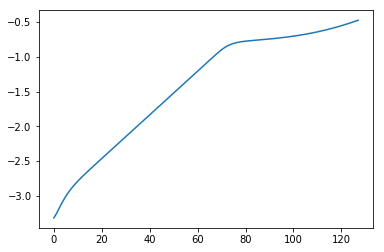

(1000, 128) (1000, 3) (200, 128) (200, 3)


In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
xtrain=np.loadtxt('X_train.csv',delimiter=',')
ytrain=np.loadtxt('Y_train.csv',delimiter=',')
xtest=np.loadtxt('X_test.csv',delimiter=',')
ytest=np.loadtxt('Y_test.csv',delimiter=',')

plt.plot(xtrain[3,:])
plt.show()

mean=np.mean(xtrain,axis=0)
std=np.std(xtrain,axis=0)
xtrain=(xtrain-mean)/std
xtest=(xtest-mean)/std
#xtrain=np.expand_dims(xtrain, axis=2)
#xtest=np.expand_dims(xtest, axis=2)

ytrain=np.log10(ytrain)
ytest=np.log10(ytest)
ytrain[:,1]=ytrain[:,1]+1
ytest[:,1]=ytest[:,1]+1
'''max=np.max(ytrain,axis=0)
ytrain=ytrain/max
ytest=ytest/max
#plt.plot(ytrain[:,0])'''

print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

## Construct and train the variational autoencoder model

In [83]:
model = VAE(epochs=50, latent_dim=2, epsilon=0.2) # Choose model parameters
model.build() # Construct VAE model using Keras
model.train(xtrain, xtest) # Trains VAE model based on custom loss function

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
dense_76 (Dense)                (None, 256)          33024       input_31[0][0]                   
__________________________________________________________________________________________________
dense_77 (Dense)                (None, 2)            514         dense_76[0][0]                   
__________________________________________________________________________________________________
dense_78 (Dense)                (None, 2)            514         dense_76[0][0]                   
__________________________________________________________________________________________________
lambda_16 

## Encoding samples to latent space:

We predict the latent variable coordinates for the test set:

In [84]:
zpred = model.predict_latent(xtrain)
print(zpred.shape)

(1000, 2)


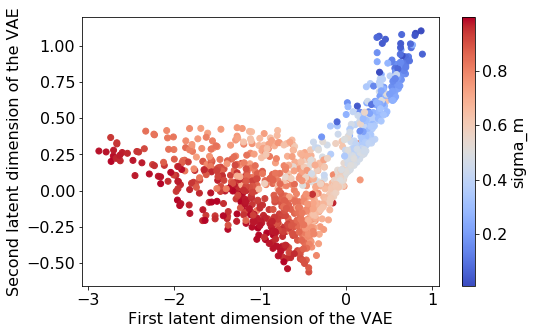

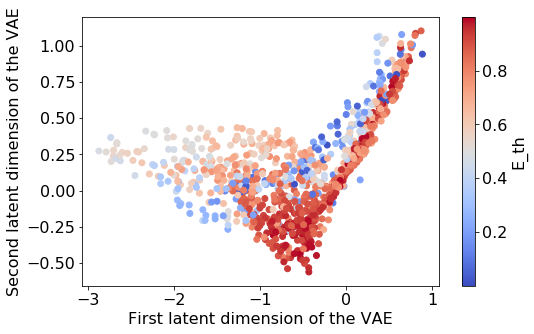

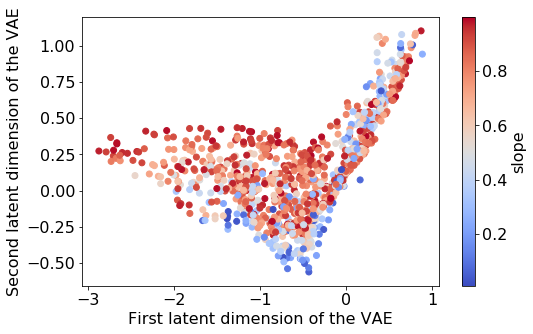

In [86]:
# To make plots pretty
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

plt.rc('font',**{'size':16})
fig, ax = plt.subplots(1,figsize=golden_size(8))
sc = ax.scatter(zpred[:,0], zpred[:,1], c=ytrain[:,0], cmap="coolwarm")
ax.set_xlabel('First latent dimension of the VAE')
ax.set_ylabel('Second latent dimension of the VAE')
plt.colorbar(sc, label='sigma_m')
plt.savefig('Sigma_m.png')
plt.show()

plt.rc('font',**{'size':16})
fig, ax = plt.subplots(1,figsize=golden_size(8))
sc = ax.scatter(zpred[:,0], zpred[:,1], c=ytrain[:,1], cmap="coolwarm")
ax.set_xlabel('First latent dimension of the VAE')
ax.set_ylabel('Second latent dimension of the VAE')
plt.colorbar(sc, label='E_th')
plt.savefig('E_th.png')
plt.show()

plt.rc('font',**{'size':16})
fig, ax = plt.subplots(1,figsize=golden_size(8))
sc = ax.scatter(zpred[:,0], zpred[:,1], c=ytrain[:,2], cmap="coolwarm")
ax.set_xlabel('First latent dimension of the VAE')
ax.set_ylabel('Second latent dimension of the VAE')
plt.colorbar(sc, label='slope')
plt.savefig('Slope.png')
plt.show()